# *Cosmian Cloudproof encryption:* Protect your data with a fine-grained permission system

This notebook demonstrates how data can be encrypted with policy attributes.

Users can decrypt data only if they possess a key with the proper attributes.

This notebook also shows how the policy can be updated.

## Imports

In [2]:
import json
import abe_gpsw

def abe_decrypt(user, user_decryption_key, encrypted_data):
    try:
        cleartext = abe_gpsw.decrypt(
            user_decryption_key, encrypted_data)
        cleartext = str(bytes(cleartext), "utf-8") 
        print("%s SUCCEEDS               : '%s' \n" % (user, cleartext))
    except Exception as ex:
        print("%s FAILS (as expected)    : '%s' \n" % (user, ex))

## Policy

In this demo, we will create an Policy which combines 2 axes: `Security Level` and `Department`.

Users can decrypt data only if they possess a key with a sufficient security level and the attribute for the department.

Two Policy Axes are defined, creating a 2 dimensional matrix of authorizations. A user must possess keys with attributes from these two axes to be able to decrypt files.

### Policy Axis 1: Security Level
The first Policy Axis is the 'Security Level' axis.

It is made of 5 levels: `Protected`, `Low Secret`, `Medium Secret`, `High Secret` and `Top Secret`.

It is hierarchical: an user being granted access to level `n` is automatically granted access to all levels below `n`.



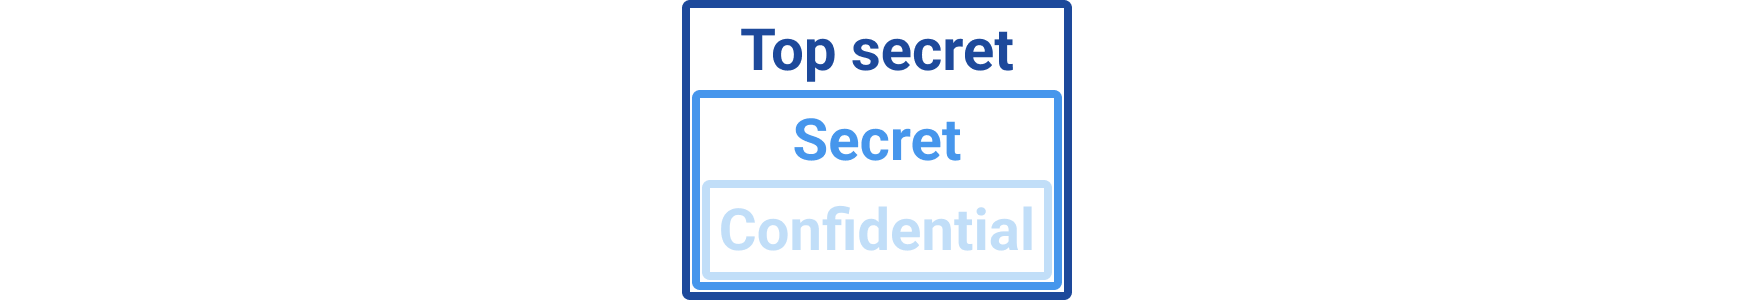

### Policy Axis 2: Department Security
The second Policy Axis is the `Department` axis.

It is made of 3 values: `human resources`, `marketing`, `finance`.

It is *not* hierarchical: granting access to an attribute of this axis to a user does not give access to any other attribute. Each attribute must be granted individually.

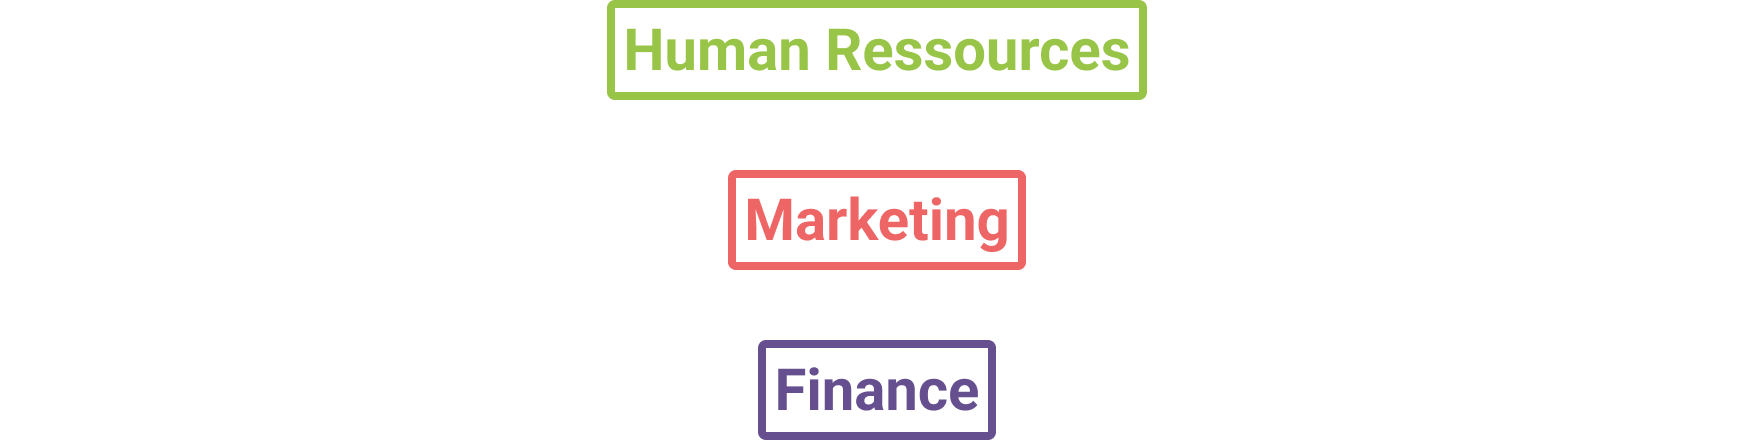

In [3]:
policy_axis_json = [
    {
        "name": "Security Level",
        "attributes": [
            "Protected",
            "Low Secret",
            "Medium Secret",
            "High Secret",
            "Top Secret"
        ],
        "hierarchical": True
    },
    {
        "name": "Departments",
        "attributes": [
            "R&D",
            "Human Resources",
            "Marketing",
            "Finance"
        ],
        "hierarchical": False
    }
]
policy_axis = bytes(json.dumps(policy_axis_json), 'utf-8')


## Master Authority

The Master Authority possesses the keys for the given Policy Group:

 - a Secret Key which is used to delegate authority to "delegate authorities", which are the ones generating user keys
 - and a Public Key which is used to encrypt files with proper level of security.

The second parameter fixes the maximum number of attribute update (see below) for this Policy.

In [4]:
policy = abe_gpsw.generate_policy(
    policy_axis_bytes=policy_axis, max_attribute_value=100)
master_keys = abe_gpsw.generate_master_keys(policy_bytes=policy)

## User Keys

The Master Authority can generate User Keys up to the level allowed by their policy. 

3 users are created:
* Alice, from `marketing`, with `medium secret` access
* Bob, from `marketing`, with `top secret` access
* Carol, from `HR`, with `medium secret` access

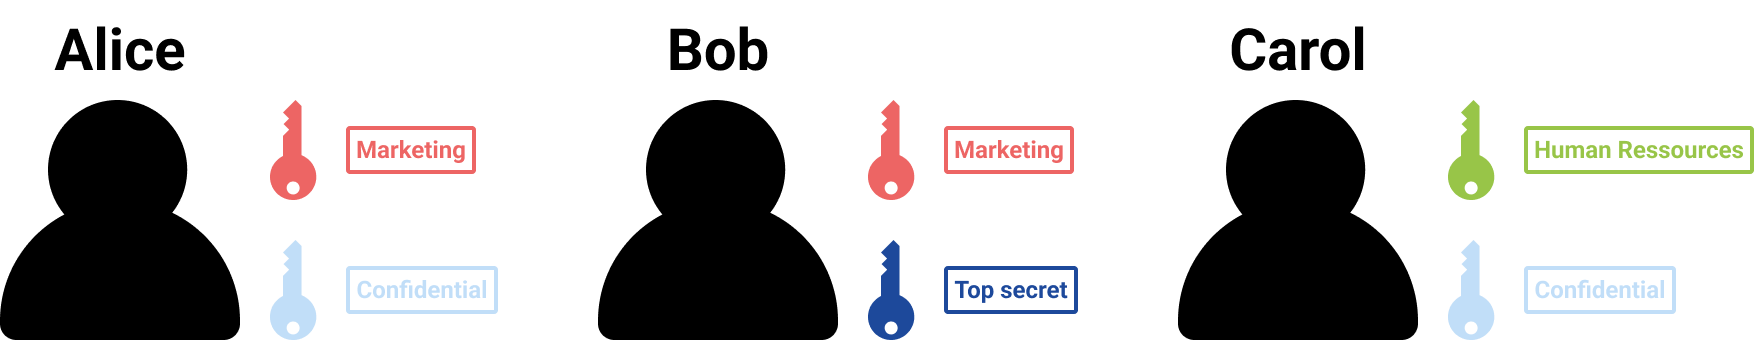

In [5]:
alice_key = abe_gpsw.generate_user_private_key(
    master_private_key_bytes=master_keys[0],
    access_policy_str="Departments::Marketing && Security Level::Medium Secret",
    policy_bytes=policy,
)

bob_key = abe_gpsw.generate_user_private_key(
    master_private_key_bytes=master_keys[0],
    access_policy_str="Departments::Marketing && Security Level::Top Secret",
    policy_bytes=policy,
)

carol_key = abe_gpsw.generate_user_private_key(
    master_private_key_bytes=master_keys[0],
    access_policy_str="Departments::Human Resources && Security Level::Medium Secret",
    policy_bytes=policy
)

## Encryption and Decryption

Data is encrypted using the Master Authority Public Key with two attributes: one for the Security Level and one for the Department.

Anyone - who has access to the Public Key - can encrypt data with any attribute combination.

However, only users possessing user keys with the right combination of attributes can decrypt data.

### A Medium Secret marketing message
Let us create an encrypted `marketing` message with the Security Level `Medium Secret`. 

In [6]:
metadata = bytes(json.dumps({"uid": [0, 0, 0, 0, 0, 0, 0, 1]}), 'utf-8')
attributes =  bytes(json.dumps(['Security Level::Medium Secret', 'Departments::Marketing']), 'utf8')
plaintext = bytes("✅ Marketing message medium secret", 'utf-8')

marketing_medium_secret_msg = abe_gpsw.encrypt(
    metadata_bytes=metadata,
    policy_bytes=policy,
    attributes_bytes=attributes,
    public_key_bytes=master_keys[1],
    plaintext=plaintext,
)

Alice and Bob are able to decrypt the message. Carol is not.

In [7]:
abe_decrypt("Alice", alice_key, marketing_medium_secret_msg)

abe_decrypt("Bob", bob_key, marketing_medium_secret_msg)

abe_decrypt("Carol", carol_key, marketing_medium_secret_msg)

Alice SUCCEEDS               : '✅ Marketing message medium secret' 

Bob SUCCEEDS               : '✅ Marketing message medium secret' 

Carol FAILS (as expected)    : 'Error decrypting header: invalid encrypted data' 



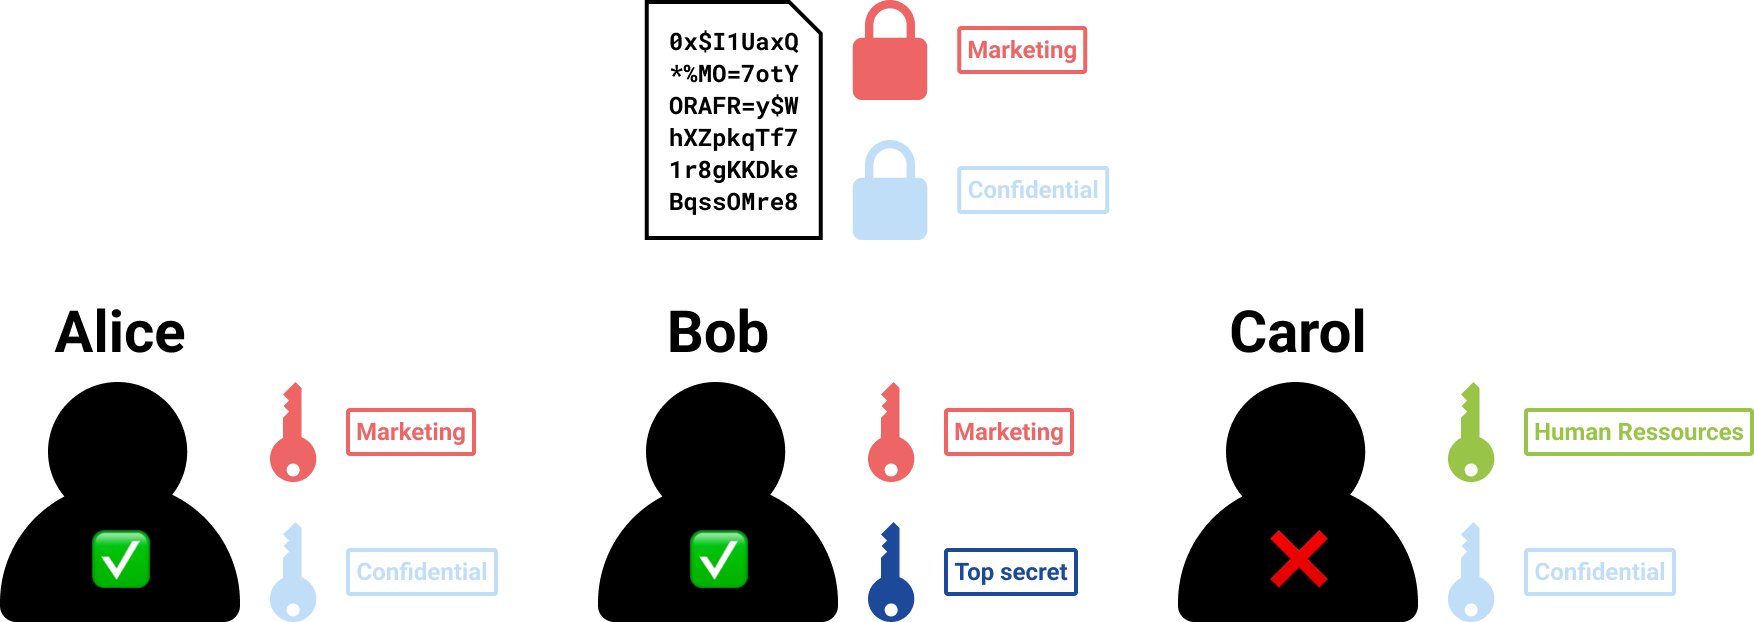

### A top secret marketing message

In the case of a top secret marketing message, only Bob succeeds:

In [8]:
attributes =  bytes(json.dumps(['Security Level::Top Secret', 'Departments::Marketing']), 'utf8')
plaintext = bytes("✅ Marketing message top_secret", 'utf-8')

marketing_top_secret_msg = abe_gpsw.encrypt(
    metadata_bytes=metadata,
    policy_bytes=policy,
    attributes_bytes=attributes,
    public_key_bytes=master_keys[1],
    plaintext=plaintext,
)


abe_decrypt("Alice", alice_key, marketing_top_secret_msg)

abe_decrypt("Bob", bob_key, marketing_top_secret_msg)

abe_decrypt("Carol", carol_key, marketing_top_secret_msg)

Alice FAILS (as expected)    : 'Error decrypting header: invalid encrypted data' 

Bob SUCCEEDS               : '✅ Marketing message top_secret' 

Carol FAILS (as expected)    : 'Error decrypting header: empty input matrix' 



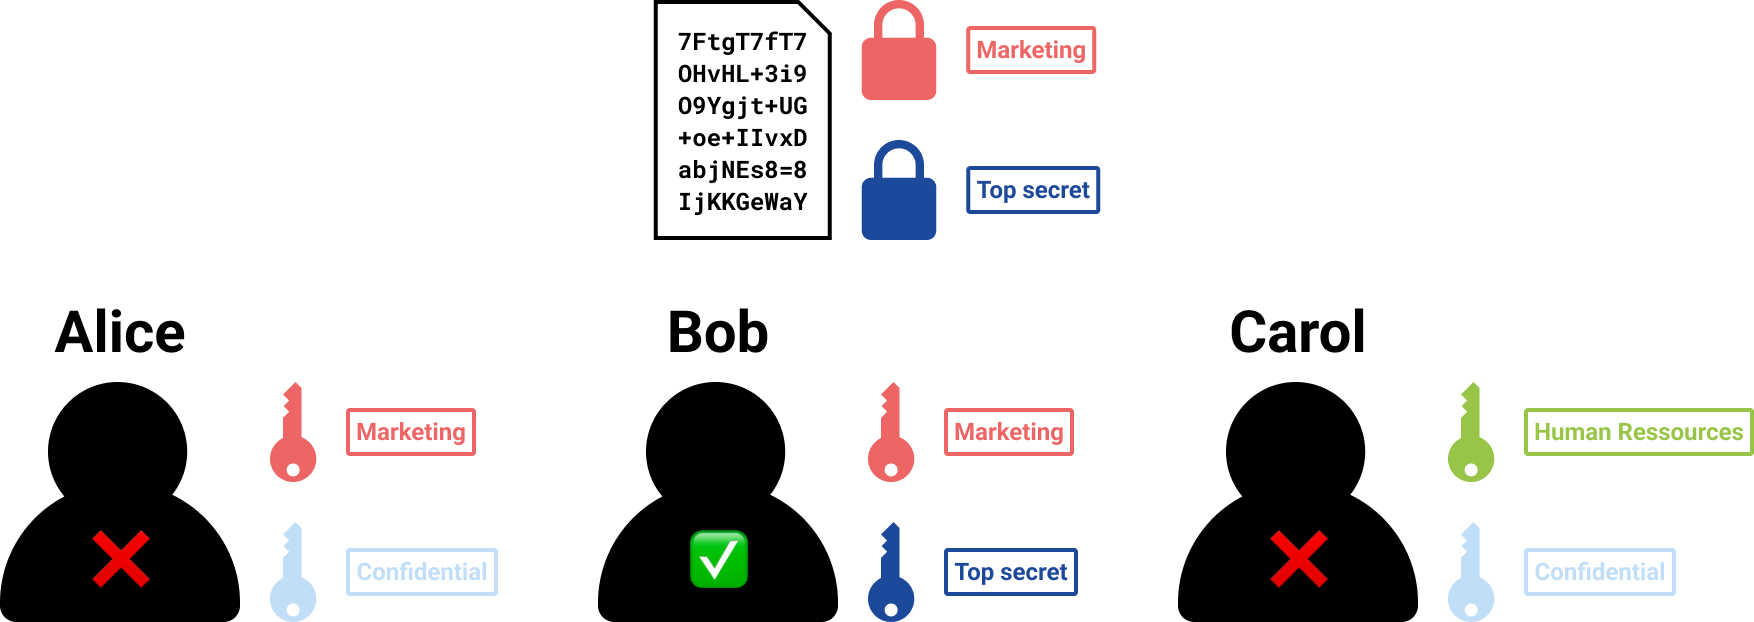

### A Medium Secret human resources message
Likewise, in the case of a `Medium Secret` message from `Human Resources`, only the Carol succeed:

In [9]:
attributes =  bytes(json.dumps(['Security Level::Medium Secret', 'Departments::Human Resources']), 'utf8')
plaintext = bytes("✅ human resources message medium secret", 'utf-8')

human_resources_medium_secret_msg = abe_gpsw.encrypt(
    metadata_bytes=metadata,
    policy_bytes=policy,
    attributes_bytes=attributes,
    public_key_bytes=master_keys[1],
    plaintext=plaintext,
)

abe_decrypt("Alice", alice_key, human_resources_medium_secret_msg)

abe_decrypt("Bob", bob_key, human_resources_medium_secret_msg)

abe_decrypt("Carol", carol_key, human_resources_medium_secret_msg)

Alice FAILS (as expected)    : 'Error decrypting header: invalid encrypted data' 

Bob FAILS (as expected)    : 'Error decrypting header: invalid encrypted data' 

Carol SUCCEEDS               : '✅ human resources message medium secret' 



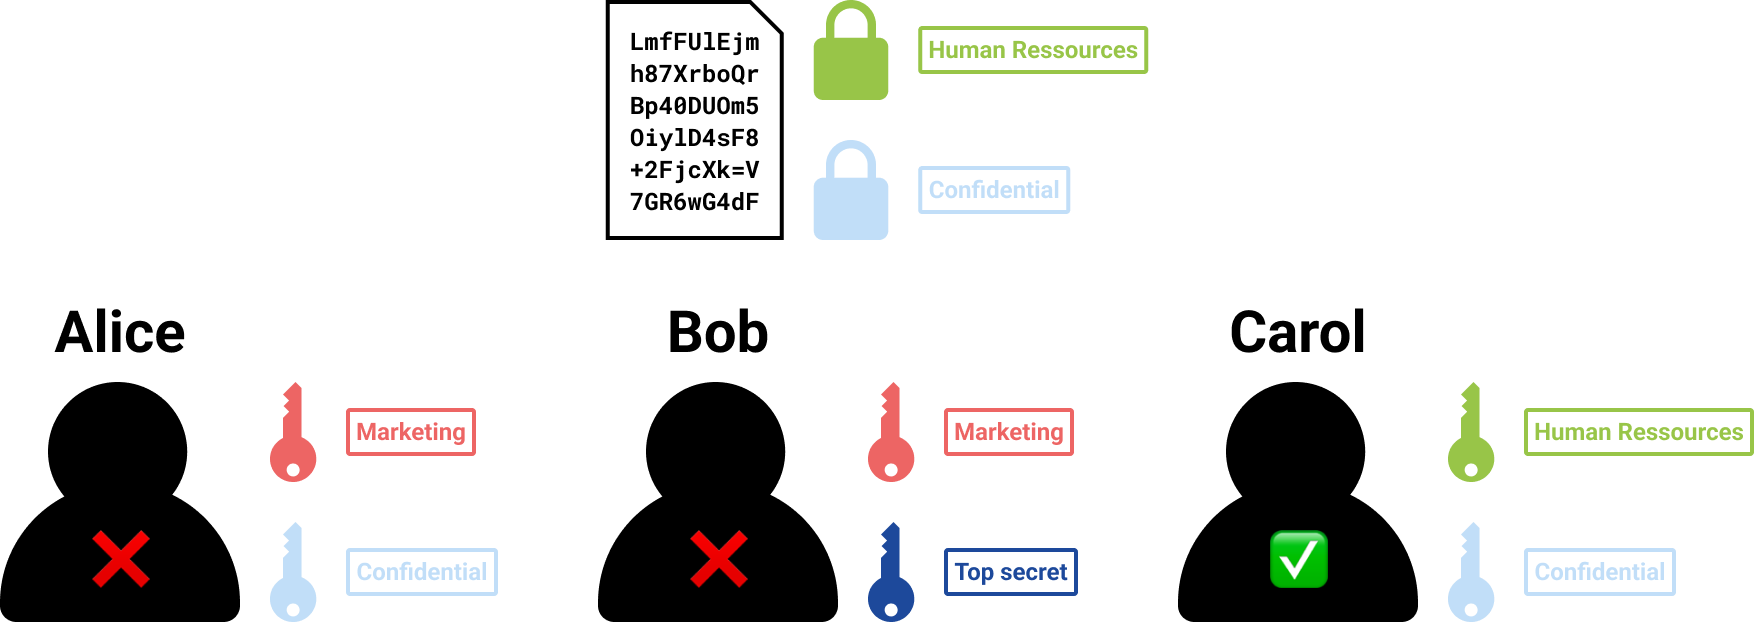

# Attributes rotation

At anytime the Master Authority can rotate an attribute. When that happens future encryption of data for a given attribute cannot be decrypted with keys which are not "refreshed" for that attribute.

Let's revoke the security level `Medium Secret`

In [10]:
new_policy = abe_gpsw.rotate_attributes(bytes(json.dumps(
    ['Security Level::Medium Secret']), 'utf8'), policy)

We now encrypt a new `marketing` message at the level `Medium Secret`


In [11]:
metadata = bytes(json.dumps({"uid": [0, 0, 0, 0, 0, 0, 0, 1]}), 'utf-8')
attributes =  bytes(json.dumps(['Security Level::Medium Secret', 'Departments::Marketing']), 'utf8')
plaintext = bytes("✅ New marketing message medium secret", 'utf-8')

new_marketing_medium_secret_msg = abe_gpsw.encrypt(
    metadata_bytes=metadata,
    policy_bytes=new_policy,
    attributes_bytes=attributes,
    public_key_bytes=master_keys[1],
    plaintext=plaintext,
)

Users' key need to be refreshed.

In [12]:
abe_decrypt("Alice", alice_key, new_marketing_medium_secret_msg)

Alice FAILS (as expected)    : 'Error decrypting header: invalid encrypted data' 



Keys need to be refreshed.

In [13]:
alice_key = abe_gpsw.generate_user_private_key(
    master_private_key_bytes=master_keys[0],
    access_policy_str="Departments::Marketing && Security Level::Medium Secret",
    policy_bytes=new_policy,
)

New messages can now be decrypted

In [14]:
abe_decrypt("Alice", alice_key, new_marketing_medium_secret_msg)

Alice SUCCEEDS               : '✅ New marketing message medium secret' 



Older messages can still be decrypted as well

In [15]:
abe_decrypt("Alice", alice_key, marketing_medium_secret_msg)

Alice SUCCEEDS               : '✅ Marketing message medium secret' 

